## A.I. Assignment 5

## Learning Goals

By the end of this lab, you should be able to:
* Get more familiar with tensors in pytorch 
* Create a simple multilayer perceptron model with pytorch
* Visualise the parameters


### Task

Build a fully connected feed forward network that adds two bits. Determine the a propper achitecture for this network (what database you use for this problem? how many layers? how many neurons on each layer? what is the activation function? what is the loss function? etc)

Create at least 3 such networks and compare their performance (how accurate they are?, how farst they are trained to get at 1 accuracy?)

Display for the best one the weights for each layer.


In [63]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import OrderedDict

In [69]:
# define the Model Class using nn.Sequential with OrderedDict
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(MLP, self).__init__()
        
        # Choose activation function
        if activation_fn == 'ReLU':
            activation = nn.ReLU()
        elif activation_fn == 'Tanh':
            activation = nn.Tanh()
        elif activation_fn == 'LeakyReLU':
            activation = nn.LeakyReLU(negative_slope=0.01)
        else:
            raise ValueError("Unknown activation function")

        self.model = nn.Sequential(OrderedDict([
            ('hidden', nn.Linear(input_size, hidden_size)),  # hidden layer
            ('activation', activation),                      # chosen activation function
            ('output', nn.Linear(hidden_size, output_size)) # output layer
        ]))
        
    def forward(self, x):
        return self.model(x)

In [70]:
# generate the dataset with 2-bit outputs for addition
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0, 0], [0, 1], [0, 1], [1, 0]], dtype=torch.float32)
print(X)
print(y)


tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])
tensor([[0., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])


In [93]:
# function to train and evaluate the model
def train_and_evaluate(model, X, y, epochs=1000):
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss which implies Sigmoid activation for the output
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    losses = []

    # Training loop
    for epoch in range(epochs):
        model.train()

        # forward pass
        y_pred = model(X)

        # compute loss
        loss = criterion(y_pred, y)

        # backward pass - compute gradients
        optimizer.zero_grad()
        loss.backward()

        # update model parameters
        optimizer.step()

        # Store loss for plotting
        losses.append(loss.item())

    # Evaluation
    with torch.no_grad():
        predictions = model(X)
        predictions = torch.sigmoid(predictions) # apply sigmoid to raw output
        predicted = predictions.round() # round to get 0 or 1
        
        #compute accuracy
        accuracy = ((predicted.eq(y)).all(dim=1).sum().float() / y.size(0))
    
    return accuracy, losses, model

In [106]:
# define the 3 different models
architectures = [
    (2, 4, 'ReLU'),        # 4 hidden neurons, ReLU activation
    (2, 2, 'Tanh'),        # 2 hidden neurons, Tanh activation
    (2, 3, 'LeakyReLU')    # 3 hidden neurons, LeakyReLU activation
]



--- Model Architecture: 4 hidden neurons, Activation: ReLU ---
model.hidden.weight: tensor([[-0.4990, -0.4631],
        [-0.2233, -0.0775],
        [-2.7203, -2.7270],
        [ 2.8254,  2.8244]])
model.hidden.bias: tensor([-0.2342, -0.1033,  2.8739, -2.8255])
model.output.weight: tensor([[ 0.4694,  0.2860, -3.4578,  3.4956],
        [ 0.2469,  0.0800, -3.8582, -4.0091]])
model.output.bias: tensor([-4.1039,  5.2057])
Accuracy: 100.00%


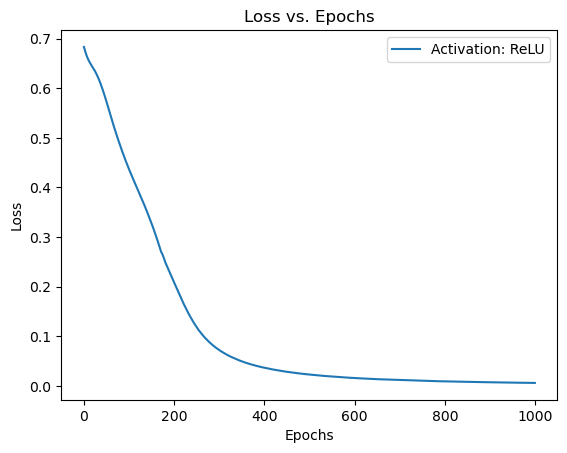


--- Model Architecture: 2 hidden neurons, Activation: Tanh ---
model.hidden.weight: tensor([[-3.8560, -3.9134],
        [ 3.0124,  2.9732]])
model.hidden.bias: tensor([ 1.9890, -4.3664])
model.output.weight: tensor([[-1.4226,  5.4147],
        [-5.3629, -5.5032]])
model.output.bias: tensor([-1.8495, -4.7243])
Accuracy: 100.00%


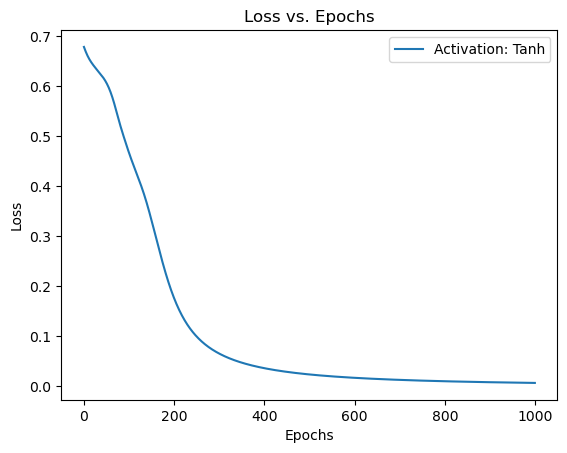


--- Model Architecture: 3 hidden neurons, Activation: LeakyReLU ---
model.hidden.weight: tensor([[ 3.2163,  3.2160],
        [-0.6161, -0.6234],
        [ 2.3432,  2.3383]])
model.hidden.bias: tensor([-3.2158e+00,  3.0580e+00,  1.1936e-03])
model.output.weight: tensor([[ 3.1994, -2.9928,  0.7325],
        [-6.0942, -1.7069,  3.7599]])
model.output.bias: tensor([-1.2673,  0.2062])
Accuracy: 100.00%


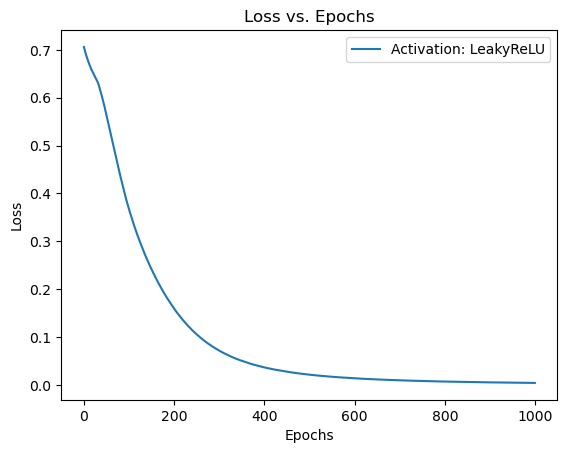

In [110]:
#evaluate and plot the 3 models
for architecture in architectures:
    input_size, hidden_size, activation_fn = architecture
    model = MLP(input_size=2, hidden_size=hidden_size, output_size=2, activation_fn=activation_fn)  # Output size is 2 (for 2 bits)

    # train model
    accuracy, losses, trained_model = train_and_evaluate(model, X, y)

    # print the params and weights of the model
    print(f"\n--- Model Architecture: {hidden_size} hidden neurons, Activation: {activation_fn} ---")
    for name, param in trained_model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.data}")

    # print the performance
    print(f"Accuracy: {accuracy.item() * 100:.2f}%")

    # plot the loss for the current model
    plt.figure()
    plt.plot(range(len(losses)), losses, label=f'Activation: {activation_fn}')
    plt.title(f"Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()